# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    # конечные loader-ы
    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

Посмотрим на изображения:

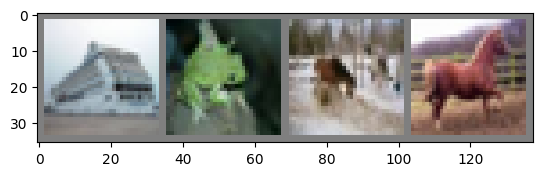

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
n_classes = 10
in_channels = 3

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        # основной блок
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        
        # параллельный
        self.paralel = nn.Conv2d(in_channels, 32, kernel_size=1)

        # avgpool
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        # fc
        self.fc = nn.Linear(32*4*4, n_classes)

    def forward(self, x):
        block_out = self.block(x)
        paralel_out = self.paralel(x)
        out = F.relu(block_out + paralel_out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)  # вектор
        out = self.fc(out)

        return out

In [8]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (paralel): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [9]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [9]:
device = torch.device("mps")
print(device)

mps


In [11]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():
        for data, target in loader:
            # на девайс
            data, target = data.to(device), target.to(device)
            # предсказ
            output = model(data)
            # loss
            loss = F.cross_entropy(output, target)
            loss_log.append(loss.item())
            # accuracy
            pred = output.argmax(dim=1)
            correct = (pred == target).float().sum()  # кол-во верных предсказ
            acc = correct / len(target)  # accuracy батча
            acc_log.append(acc.item())      

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        
        data, target = data.to(device), target.to(device)
        # обнул градиенты
        optimizer.zero_grad()
        # предсказ
        output = model(data)
        # loss
        loss = F.cross_entropy(output, target)
        # оптимиз и обновл весов
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
        # accuracy
        pred = output.argmax(dim=1)
        correct = (pred == target).float().sum()
        acc = correct / len(target)
        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        # обуч одной эпохи
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        # валидация
        val_loss, val_acc = test(model, val_loader)

        # записываем метрики
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau): # модификация для работы с scheduler, который учитывает значение метрики
                scheduler.step(np.mean(train_loss))
            else:
                scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [15]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.4680310913805987, train acc: 0.4739610537532479
 val loss: 1.2853126553778953, val acc: 0.5550531914893617

Epoch 1
 train loss: 1.17597078743103, train acc: 0.5895591211493316
 val loss: 1.1094889965463193, val acc: 0.6106604609083622

Epoch 2
 train loss: 1.0543368045765042, train acc: 0.6319616740974692
 val loss: 1.0106857264295537, val acc: 0.6494902481424047

Epoch 3
 train loss: 0.9934918294223178, train acc: 0.6547034147452611
 val loss: 1.0356983940652076, val acc: 0.6424645390916378

Epoch 4
 train loss: 0.9628583030465316, train acc: 0.6645093366258541
 val loss: 0.9879357718406839, val acc: 0.6553634752618506

Epoch 5
 train loss: 0.9265414916619087, train acc: 0.6765392399793133
 val loss: 1.007685286187111, val acc: 0.6538342199427016

Epoch 6
 train loss: 0.9041538057641094, train acc: 0.6865002285191956
 val loss: 0.9258985620863894, val acc: 0.680718085106383

Epoch 7
 train loss: 0.8848402492524937, train acc: 0.6938250848318585
 val loss: 0.974

Посчитайте точность на тестовой выборке:

In [16]:
test(net, test_loader)

(0.8904836090507021, 0.6945660828025477)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [23]:
# кол-во батчей в эпохе
len(train_loader)  

547

In [13]:
import matplotlib.pyplot as plt

In [12]:
def plot_training_metrics(train_loss_log, train_acc_log, val_loss_log, val_acc_log, steps_per_epoch):
    
    # ось Х треина
    train_steps = np.arange(len(train_loss_log))
    
    # ось X валидации
    val_steps = np.arange(1, len(val_loss_log)+1) * steps_per_epoch - 1
    
    plt.figure(figsize=(14, 6))
    
    # loss
    plt.subplot(1, 2, 1)
    plt.plot(train_steps, train_loss_log, label='Loss обучения')
    plt.plot(val_steps, val_loss_log, label='Loss валидации')
    plt.xlabel('Шаг обучения')
    plt.ylabel('Loss')
    plt.title('Loss обучения и валидации')
    plt.legend()
    plt.grid(True)
    
    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_steps, train_acc_log, label='Accuracy на обучении')
    plt.plot(val_steps, val_acc_log, label='Accuracy на валидации')
    plt.xlabel('Шаг обучения')
    plt.ylabel('Accuracy')
    plt.title('Accuracy на обучении и валидации')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

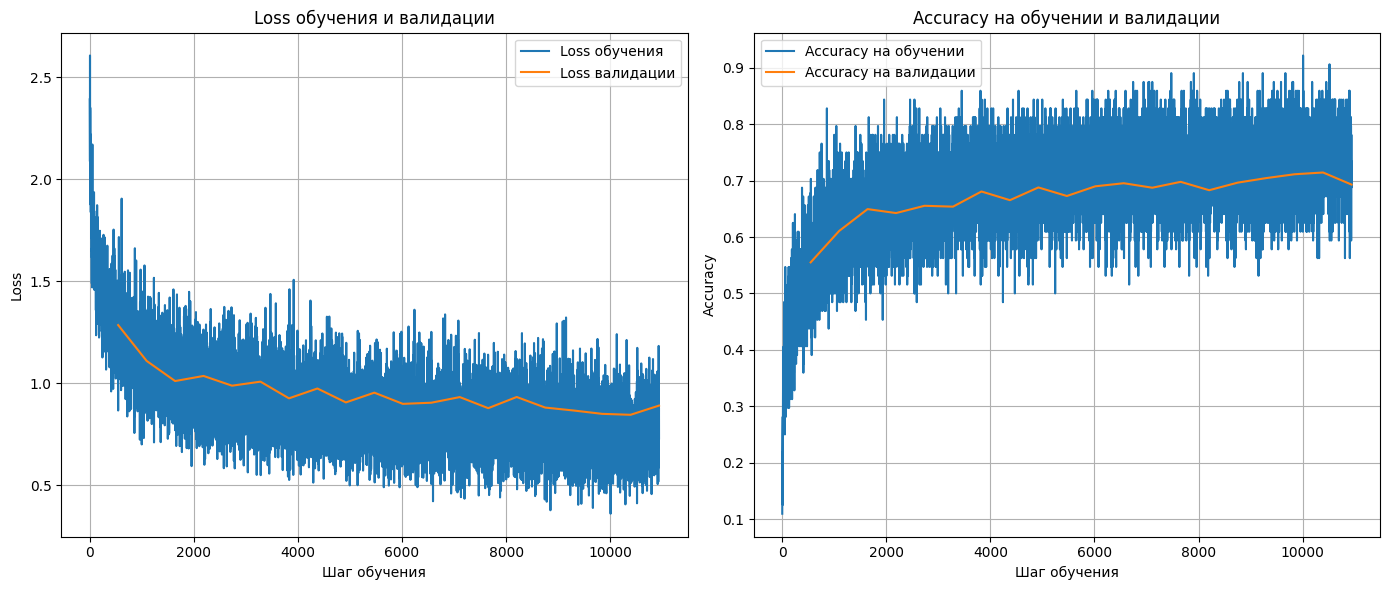

In [39]:
plot_training_metrics(train_loss_log, train_acc_log, val_loss_log, val_acc_log, steps_per_epoch=547)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [40]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4989990874225958, train acc: 0.4634940585009141
 val loss: 1.3367346104155196, val acc: 0.5313164893617022

Epoch 1
 train loss: 1.1921217693271322, train acc: 0.5848663162705667
 val loss: 1.140276757706987, val acc: 0.6032136525245423

Epoch 2
 train loss: 1.0718649249843968, train acc: 0.6293541067697013
 val loss: 1.0748123125827058, val acc: 0.6342641843126176

Epoch 3
 train loss: 1.0180945915103612, train acc: 0.6463298185216008
 val loss: 1.018305961375541, val acc: 0.6478058510638298

Epoch 4
 train loss: 0.9798140931173042, train acc: 0.6588779707495429
 val loss: 0.9939836451347838, val acc: 0.6551861702127659

Epoch 5
 train loss: 0.9562071568351341, train acc: 0.6685492296105547
 val loss: 0.9918925658185431, val acc: 0.6550088651636814

Epoch 6
 train loss: 0.9214881346910048, train acc: 0.6791590493601463
 val loss: 1.0074367804730193, val acc: 0.6494459220703612

Epoch 7
 train loss: 0.9071764938356236, train acc: 0.6848761099348121
 val loss: 0.9

Посчитайте точность на тестовой выборке:

In [41]:
test(net, test_loader)

(0.8359115357231942, 0.7174562101910829)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [42]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # lr = 0.001 (const)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8259505977142445, train acc: 0.35899549488393656
 val loss: 1.6196017610265854, val acc: 0.4351728723404255

Epoch 1
 train loss: 1.551705068818394, train acc: 0.455238802559415
 val loss: 1.462051369788799, val acc: 0.48723404255319147

Epoch 2
 train loss: 1.4283759681136778, train acc: 0.4967109558787163
 val loss: 1.3718493771045766, val acc: 0.513984929120287

Epoch 3
 train loss: 1.3439401052551687, train acc: 0.5276589840378142
 val loss: 1.2988659178957027, val acc: 0.5439494680851064

Epoch 4
 train loss: 1.2853836492385027, train acc: 0.549290774400317
 val loss: 1.2606517954075591, val acc: 0.5584663120990104

Epoch 5
 train loss: 1.244311591062075, train acc: 0.5633161399765468
 val loss: 1.2172553148675471, val acc: 0.5716976950777338

Epoch 6
 train loss: 1.2046691551940751, train acc: 0.5769905653906479
 val loss: 1.211779457711159, val acc: 0.5704343972053934

Epoch 7
 train loss: 1.175743385468366, train acc: 0.5896856229091693
 val loss: 1.17439

In [43]:
test(net, test_loader)

(0.9724509214899343, 0.6644108280254777)

Закономерно, качество сильно хуже, так как очень медленно спускается

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

Scheduler довольно много, мне показались интересными эти 3:
1) **lr_scheduler.ExponentialLR** - по экспоненте уменьшает learning_rate после каждой эпохи
2) **lr_scheduler.ReduceLROnPlateau** - уменьшает learning_rate только тогда, когда отслеживаемая метрика перестает улучшаться
3) **lr_scheduler.CyclicLR** - learning_rate циклически меняется между заданным базовым и заданным максимальным. Есть разные амплитуды, то есть как сменяется базовый и максимальный learning_rate



**ExponentialLR**

In [48]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.3)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.5246990345949665, train acc: 0.45261491249422703
 val loss: 1.346647245072304, val acc: 0.5232047872340425

Epoch 1
 train loss: 1.146595327466236, train acc: 0.5957658658079953
 val loss: 1.100431923156089, val acc: 0.6141843972053934

Epoch 2
 train loss: 1.019576549747962, train acc: 0.6446852964064756
 val loss: 1.0112800532198967, val acc: 0.6507535460147452

Epoch 3
 train loss: 0.9751303567528943, train acc: 0.6614569730688928
 val loss: 0.9949480356054103, val acc: 0.6568484042553191

Epoch 4
 train loss: 0.9619967146373101, train acc: 0.6657417079866259
 val loss: 0.9845114842374274, val acc: 0.6587765957446808

Epoch 5
 train loss: 0.9566773518347871, train acc: 0.6686267628312329
 val loss: 0.9824075118024298, val acc: 0.6612367021276596

Epoch 6
 train loss: 0.9551593327870971, train acc: 0.6688838469262969
 val loss: 0.9821947688752032, val acc: 0.6603280140998515

Epoch 7
 train loss: 0.9542666354388598, train acc: 0.6684023243199755
 val loss: 0.98

In [49]:
test(net, test_loader)

(0.9912994371098318, 0.6517714968152867)

**ReduceLROnPlateau**

In [53]:
scheduler

In [58]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',  # цель - уменьшение, так как loss (по умолчанию)
                                                 factor=0.1,  # множитель
                                                 patience=1,  # сколько эпох ждать улучшения
                                                 threshold=1e-4  # минимальное значимое улучшение
                                                 )
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.5039883826942724, train acc: 0.4605110668504042
 val loss: 1.2703796929501472, val acc: 0.5565824468085107

Epoch 1
 train loss: 1.2042808802951623, train acc: 0.5739790088951696
 val loss: 1.1375845361263195, val acc: 0.604809397078575

Epoch 2
 train loss: 1.0856880599009708, train acc: 0.6189319992632055
 val loss: 1.095592725276947, val acc: 0.6184175531914894

Epoch 3
 train loss: 1.0197687517354432, train acc: 0.6435386197440585
 val loss: 1.0085450484397565, val acc: 0.652216311972192

Epoch 4
 train loss: 0.9841181500738239, train acc: 0.6574293222462237
 val loss: 1.0616056713652104, val acc: 0.6324911348363187

Epoch 5
 train loss: 0.9477747597031881, train acc: 0.6676841211493316
 val loss: 0.9717740348044862, val acc: 0.6561391843126175

Epoch 6
 train loss: 0.9224136891269161, train acc: 0.6786122355862118
 val loss: 0.9987464582666438, val acc: 0.6574911348363186

Epoch 7
 train loss: 0.9020953168598782, train acc: 0.6841538260798131
 val loss: 0.95

In [59]:
test(net, test_loader)

(0.8701481031384438, 0.7018312101910829)

**CyclicLR**

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, 
                                        base_lr=0.001,  # нижняя граница LR
                                        max_lr=0.1,     # верхняя граница LR
                                        step_size_up=100,  # сколько batches потребуется чтобы от base_lr вырасти до max_lr
                                        step_size_down=None,  # сколько batches потребуется спуститься от max_lr до base_lr
                                        mode='triangular'  # форма роста / снижения
                                        )
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.8195478386591295, train acc: 0.3648512992715051
 val loss: 1.6138711066956215, val acc: 0.4396276595744681

Epoch 1
 train loss: 1.5043277040913947, train acc: 0.4707373008540605
 val loss: 1.400882601737976, val acc: 0.5016179078436912

Epoch 2
 train loss: 1.356720003610991, train acc: 0.5198322015880884
 val loss: 1.2910956948361498, val acc: 0.5429742908224147

Epoch 3
 train loss: 1.2537391538811775, train acc: 0.5573991250512369
 val loss: 1.20870023458562, val acc: 0.5682845744680851

Epoch 4
 train loss: 1.1574431321084826, train acc: 0.5914076782449725
 val loss: 1.0868271234187674, val acc: 0.620434397078575

Epoch 5
 train loss: 1.0746719224797305, train acc: 0.6238370004911963
 val loss: 1.0193710091266226, val acc: 0.6489140071767442

Epoch 6
 train loss: 1.0212777941274904, train acc: 0.6433182619171561
 val loss: 0.9984688725877315, val acc: 0.6454565603682335

Epoch 7
 train loss: 0.9832549320714348, train acc: 0.655723589756807
 val loss: 0.94623

In [47]:
test(net, test_loader)

(0.8722449146258603, 0.6972531847133758)

Ни одна модификация не побила MultiStepLR, наиболее близкой по качеству стал ReduceLROnPlateau

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

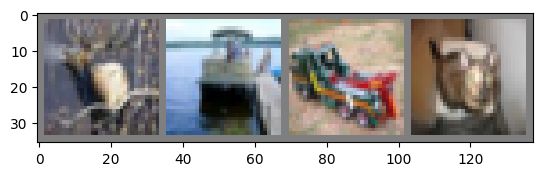

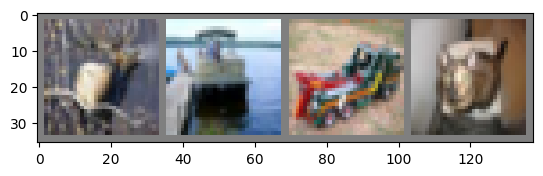

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [14]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4813555537891563, train acc: 0.4726103421103148
 val loss: 1.276956771789713, val acc: 0.5419547872340426

Epoch 1
 train loss: 1.1814427180743523, train acc: 0.5856865369859517
 val loss: 1.1006936032721337, val acc: 0.6201462765957447

Epoch 2
 train loss: 1.057044106384082, train acc: 0.6315291199213408
 val loss: 1.0554420405245841, val acc: 0.6341755319148936

Epoch 3
 train loss: 0.9948536512838639, train acc: 0.6539321624600691
 val loss: 1.0137740064174572, val acc: 0.6526595744680851

Epoch 4
 train loss: 0.9577346320997863, train acc: 0.6701570253485517
 val loss: 1.0078472588924652, val acc: 0.6468306736743197

Epoch 5
 train loss: 0.9261103217954827, train acc: 0.6780980673960837
 val loss: 0.9282647503183243, val acc: 0.6755762412192974

Epoch 6
 train loss: 0.9070256834056303, train acc: 0.688275332969547
 val loss: 0.9994766554933914, val acc: 0.6513519502700643

Epoch 7
 train loss: 0.8974963910400976, train acc: 0.6873979824552588
 val loss: 0.89

Посчитайте точность на тестовой выборке:

In [15]:
test(net, test_loader)

(0.8071125051018538, 0.7247213375796179)

Поворот изображения по горизонтали дал прирост в 0.01

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

Возьмем для сравнения:

1) **RandomAffine** - случайный поворот
2) **ColorJitter** - цветовые искажения
3) **RandomResizedCrop** - случайные вырезки

**RandomAffine**

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomAffine(degrees=10,          # поворот
                                translate=(0.1,0.1), # сдвиг
                                scale=(0.9,1.1)      # масштаб
                                ),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.6220980217949346, train acc: 0.41352180725259796
 val loss: 1.3764701523679368, val acc: 0.5017287234042553

Epoch 1
 train loss: 1.3432834112448055, train acc: 0.5225417863516311
 val loss: 1.2402565654287947, val acc: 0.562344858240574

Epoch 2
 train loss: 1.2356876781043449, train acc: 0.5617042634997115
 val loss: 1.2335449279622828, val acc: 0.5703014184819891

Epoch 3
 train loss: 1.1794902631090154, train acc: 0.5832462783705382
 val loss: 1.147944444544772, val acc: 0.597872340425532

Epoch 4
 train loss: 1.1341386466837016, train acc: 0.5996262079183101
 val loss: 1.2753610968589784, val acc: 0.5664007093044038

Epoch 5
 train loss: 1.1043750797372849, train acc: 0.6149247518623115
 val loss: 1.1164364786858254, val acc: 0.6030141843126176

Epoch 6
 train loss: 1.0852494732335456, train acc: 0.6182831679445299
 val loss: 1.1006408057314285, val acc: 0.6082446808510639

Epoch 7
 train loss: 1.0708739287892468, train acc: 0.6256651540560958
 val loss: 1.1

In [17]:
test(net, test_loader)

(0.8524161119749591, 0.7057125796178344)

**ColorJitter**

In [ ]:
transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2,     # яркость
                               contrast=0.2,       # контраст
                               saturation=0.2,     # насыщ
                               hue=0.1             # оттенок
                               ),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.5381816143963412, train acc: 0.45489602376599636
 val loss: 1.3349061024949906, val acc: 0.5267065602414152

Epoch 1
 train loss: 1.215117059634416, train acc: 0.5739218790962666
 val loss: 1.1405142378299795, val acc: 0.6038563829787233

Epoch 2
 train loss: 1.105495918276541, train acc: 0.614430987202925
 val loss: 1.0740371384519212, val acc: 0.6297429077168728

Epoch 3
 train loss: 1.0455411323899544, train acc: 0.63849895538752
 val loss: 1.163172994775975, val acc: 0.605873226865809

Epoch 4
 train loss: 1.0095266019840345, train acc: 0.6521733807471378
 val loss: 1.0856201346884382, val acc: 0.6220966312479466

Epoch 5
 train loss: 0.9797831949193909, train acc: 0.6611141942754742
 val loss: 0.9779637955604715, val acc: 0.6643395390916378

Epoch 6
 train loss: 0.9571651500365416, train acc: 0.6678881561298475
 val loss: 1.0169315875844753, val acc: 0.651529255319149

Epoch 7
 train loss: 0.9457260686257204, train acc: 0.6734256659390939
 val loss: 1.048271

In [19]:
test(net, test_loader)

(0.8447914495589627, 0.7155652866242038)

Тоже есть маленький прирост

**RandomResizedCrop**

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=32,            # выходной размер
                                     scale=(0.8,1.0),    # обл вырезки
                                     ratio=(0.9,1.1)     # соотношение сторон
                                     ),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.5374396494581233, train acc: 0.45172123924251883
 val loss: 1.3142046826951048, val acc: 0.5286790780564572

Epoch 1
 train loss: 1.253544947129063, train acc: 0.5605698288903593
 val loss: 1.1899137573039278, val acc: 0.5838209219435428

Epoch 2
 train loss: 1.1298419172846639, train acc: 0.6068653695326183
 val loss: 1.1144240929725322, val acc: 0.6130762412192974

Epoch 3
 train loss: 1.072745709249263, train acc: 0.6268199921961894
 val loss: 1.1558198299813778, val acc: 0.6065381204828303

Epoch 4
 train loss: 1.0319299937602153, train acc: 0.6398537477148081
 val loss: 1.1121267914772033, val acc: 0.6125221630360218

Epoch 5
 train loss: 1.002099822491571, train acc: 0.6495413293132398
 val loss: 1.0764169736111417, val acc: 0.6260195034615537

Epoch 6
 train loss: 0.9783863343529989, train acc: 0.6581434447325126
 val loss: 0.9981371042576243, val acc: 0.6565381206096487

Epoch 7
 train loss: 0.9617668882802374, train acc: 0.6652438626428845
 val loss: 1.0

In [21]:
test(net, test_loader) 

(0.9032052345336623, 0.6948646496815286)

Все вместе

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),

        transforms.RandomAffine(degrees=10,          # поворот (градусы)
                                translate=(0.1,0.1), # сдвиг по осям
                                scale=(0.9,1.1)      # масштаб 
                                ),

        transforms.ColorJitter(brightness=0.2,     # яркость
                               contrast=0.2,       # контраст
                               saturation=0.2,     # насыщ
                               hue=0.1             # оттенок
                               ),
                               
        transforms.RandomResizedCrop(size=32,            # выходной размер
                                     scale=(0.8,1.0),    # обл вырезки
                                     ratio=(0.9,1.1)     # соотношение сторон
                                     ),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.742808804651501, train acc: 0.3707397492973635
 val loss: 1.6165930250857738, val acc: 0.4241578014607125

Epoch 1
 train loss: 1.5051778960271553, train acc: 0.4644285387596221
 val loss: 1.437375286792187, val acc: 0.4904476950777338

Epoch 2
 train loss: 1.3981703102479688, train acc: 0.5059904674616331
 val loss: 1.4033719894733834, val acc: 0.49765070930440375

Epoch 3
 train loss: 1.3436215142881194, train acc: 0.5236517367458866
 val loss: 1.492962806782824, val acc: 0.4926640070499258

Epoch 4
 train loss: 1.2989730098347778, train acc: 0.541308925291302
 val loss: 1.3476361193555466, val acc: 0.5335992908224146

Epoch 5
 train loss: 1.2714934286949187, train acc: 0.5502170932358318
 val loss: 1.262855351985769, val acc: 0.5533687942839683

Epoch 6
 train loss: 1.2410860769927392, train acc: 0.5621245756227747
 val loss: 1.211118757471125, val acc: 0.5740691489361702

Epoch 7
 train loss: 1.2350294890743723, train acc: 0.5662011948756369
 val loss: 1.2961

In [24]:
test(net, test_loader)

(0.9834175846379274, 0.6628184713375797)

Без RandomResizedCrop

In [25]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),

        transforms.RandomAffine(degrees=10,          # поворот (градусы)
                                translate=(0.1,0.1), # сдвиг по осям
                                scale=(0.9,1.1)      # масштаб 
                                ),

        transforms.ColorJitter(brightness=0.2,     # яркость
                               contrast=0.2,       # контраст
                               saturation=0.2,     # насыщ
                               hue=0.1             # оттенок
                               ),
                               
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.6966175457677195, train acc: 0.3868585139567499
 val loss: 1.50298427622369, val acc: 0.46081560279460665

Epoch 1
 train loss: 1.4604555048062118, train acc: 0.47891502352039816
 val loss: 1.3375572544463137, val acc: 0.5251329787234043

Epoch 2
 train loss: 1.323914851414438, train acc: 0.5334168516739631
 val loss: 1.3422488486513178, val acc: 0.5357269503968827

Epoch 3
 train loss: 1.2580280575281524, train acc: 0.5583336053644281
 val loss: 1.2172004811307218, val acc: 0.5733820921563088

Epoch 4
 train loss: 1.2137161745013876, train acc: 0.5725793288220435
 val loss: 1.238513580028047, val acc: 0.5651374114320633

Epoch 5
 train loss: 1.1809113818940995, train acc: 0.5851070775192442
 val loss: 1.1994226549534088, val acc: 0.5836657801841167

Epoch 6
 train loss: 1.159939607384, train acc: 0.5927910354717122
 val loss: 1.1187368349826081, val acc: 0.6105496454746165

Epoch 7
 train loss: 1.1506524274510483, train acc: 0.5970390441212837
 val loss: 1.20492

In [26]:
test(net, test_loader)

(0.870791773887197, 0.7047173566878981)

Только горизонтальный поворот дал наилучший прирост. Лучшее accuracy - 72.4%

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [ ]:
# <your code here>